In [ ]:
# Import libraries
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../rfsoc_lib')
from rfsoc_calibration import RfsocCalibration

import pickle
from scipy.signal import welch
import bisect
import pyvisa
%pylab inline

In [4]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "172.24.106.21" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback

In [2]:
# Import phase calibration data
with open('pickles/calibrate_phase.pickle', 'rb') as handle:
    dac_phis = pickle.load(handle)
calibration = RfsocCalibration(dac_phis)

In [3]:
def trigger_iq_gens(iq_freq, phase, gain):
    # Config parameters
    freq = iq_freq
    phases = [phase, 0]
    gains = [DEFAULT_GAIN, gain]

    # Program DAC registers
    prog = QickProgram(soccfg)
    soc.reset_gens()
    for ch in range(2):
        prog.declare_gen(ch=ch, nqz=1)
        prog.set_pulse_registers(ch = ch,
                                gain = gains[ch],
                                freq = prog.freq2reg(freq, gen_ch=ch),
                                phase = prog.deg2reg(phases[ch]+calibration.phase(freq, ch), gen_ch=ch),
                                style = "const",
                                length = prog.us2cycles(100, gen_ch=ch),
                                mode = "periodic",
                                )
        prog.pulse(ch=ch, t=0)

    # Start DACs
    prog.config_all(soc)
    soc.tproc.start()

def diff_freq_power(lo_freq, iq_freq):
    # Record readout into multi-rate buffer
    prog = QickProgram(soccfg)
    prog.declare_readout(ch=1, length=1000,
                        freq=0, gen_ch=1, sel="input")
    prog.trigger(mr=True)
    prog.config_all(soc)
    soc.arm_mr(ch=1)
    soc.tproc.start()
    iq_mr = soc.get_mr()

    # Get power spectrum of readout
    fs_adc = soccfg['readouts'][1]['fs']
    psd_freqs, psd = welch(iq_mr[:,0], fs_adc, return_onesided=True, detrend=False, nperseg=512)

    # Obtain psd at difference frequency
    diff_freq = lo_freq - iq_freq
    i = bisect.bisect_left(psd_freqs, diff_freq)
    power_above, power_below = psd[i], psd[i-1]
    power_density = (power_below + power_above) / 2

    return power_density

def calibrate_ssb(iq_freq, lo_freq, phases, gains):
    print(f"\rCalibrating {iq_freq} MHz", end='')

    # Find phase with minimum amplitude
    phase_dict = {}
    for phase in phases:
        trigger_iq_gens(iq_freq, phase, gain=DEFAULT_GAIN)
        phase_dict[phase] = diff_freq_power(lo_freq, iq_freq)
    min_phase = min(phase_dict, key=phase_dict.get)

    # Find gain with minimum amplitude
    gain_dict={}
    for gain in gains:
        trigger_iq_gens(iq_freq, min_phase, gain)
        gain_dict[gain] = diff_freq_power(lo_freq, iq_freq)
    min_gain = min(gain_dict, key=gain_dict.get)

    return min_phase, min_gain

In [4]:
# Set calibration constants
LO_FREQ = 2000 # [MHz]

MIN_IQ_FREQ = 20 # [MHz]
MAX_IQ_FREQ = 2000 # [MHz]

DEFAULT_GAIN = 25000 # [arb.]

In [5]:
# Configure LO
rm = pyvisa.ResourceManager()
address = 'TCPIP0::172.24.106.20'
dev = rm.open_resource(address)
freq = "FREQ " + str(LO_FREQ * 1e6)
dev.write(freq)
# dev.write('POW 13') # set to 13 dBm
dev.close()

In [6]:
# Initial calibration sweep ranges
test_phases = np.arange(-180, 0, 1)
test_gains = np.arange(0, 30000, 100)

# # Test frequency in middle of range
# initial_iq_freq = (MAX_IQ_FREQ + MIN_IQ_FREQ) / 2
# # Ensure difference frequency and IQ frequency are not the same
# if 0 <= LO_FREQ - (2 * initial_iq_freq) <= 50:
#     initial_iq_freq = (LO_FREQ / 2) - 50
# elif -50 <= LO_FREQ - (2 * initial_iq_freq) < 0:
#     initial_iq_freq = (LO_FREQ / 2) + 50

initial_iq_freq = 800

# Perform initial calibration
initial_params = calibrate_ssb(initial_iq_freq, LO_FREQ, test_phases, test_gains)
print("\n----- Initial calibration complete ------")
initial_phase = initial_params[0]
initial_gain = initial_params[1]
print(f"Initial phase: {initial_phase} [deg.]")
print(f"Initial gain: {initial_gain} [arb.]")

Calibrating 800 MHz
----- Initial calibration complete ------
Initial phase: -92 [deg.]
Initial gain: 28900 [arb.]


In [7]:
# IQ frequency calibration range
iq_freq_step = 1
iq_freqs = np.arange(MIN_IQ_FREQ, MAX_IQ_FREQ+iq_freq_step, iq_freq_step)

# Phase calibration range
phase_range = 6
phase_step = 0.25
phases = np.arange(initial_phase-(phase_range/2), initial_phase+(phase_range/2)+phase_step, phase_step)
print(f"Testing phases from {np.round(min(phases), decimals=1)} to {np.round(max(phases), decimals=1)} [deg.]")

# Gain calibration range
gain_range = 5000
gain_step = 250
gains = np.arange(int(initial_gain-(gain_range/2)), int(initial_gain+(gain_range/2)+gain_step), gain_step)
print(f"Testing gains from {min(gains)} to {max(gains)} [arb.]")

# Perform calibration
ssb_params = {}
for iq_freq in iq_freqs:
    # ssb_params[iq_freq] = calibrate_ssb(iq_freq, LO_FREQ, phases, gains)
    min_phase, min_gain = calibrate_ssb(iq_freq, LO_FREQ, phases, gains)
    ssb_params[freq] = {"phases": [min_phase, 0], "gains": [DEFAULT_GAIN, min_gain]}
print("\n------ Calibration complete ------")

Testing phases from -95.0 to -89.0 [deg.]
Testing gains from 26400 to 31400 [arb.]
Calibrating 2000 MHz
------ Calibration complete ------


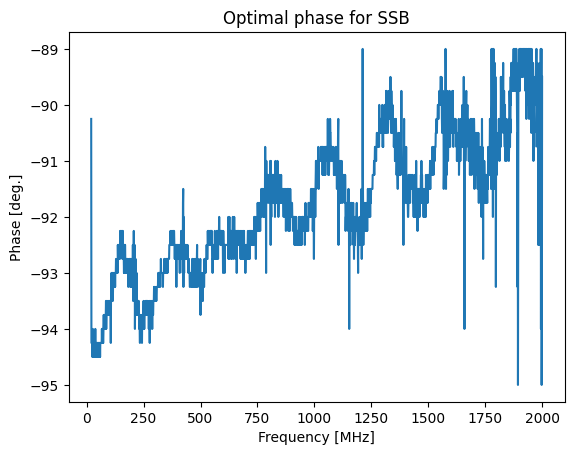

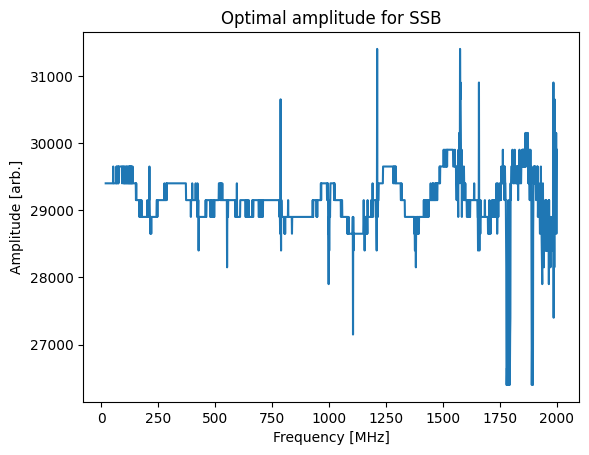

In [8]:
# Plot calibrated parameters
freqs, phases, amps = [], [], []
for freq, params in ssb_params.items():
    phases.append(params["phases"][0])
    amps.append(params["gains"][1])
    freqs.append(freq)

plt.plot(freqs, phases)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg.]")
plt.title("Optimal phase for SSB");
plt.show()

plt.plot(freqs, amps)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Amplitude [arb.]")
plt.title("Optimal amplitude for SSB");
plt.show()

In [9]:
# to save the data
with open('pickles/ssb_params.pickle', 'wb') as handle:
    pickle.dump(ssb_params, handle, protocol=pickle.HIGHEST_PROTOCOL)